0
	Initialization Time: 0.479140043259
Finishing step: 0
Finishing step: 5000
Finishing step: 10000
Finishing step: 15000
Finishing step: 20000
Finishing step: 25000
Finishing step: 30000
Total Time 9.7665989399
Pre loop Time 0.000869989395142
Inner loop time 9.42387151718
Outer loop time 0.0935263633728


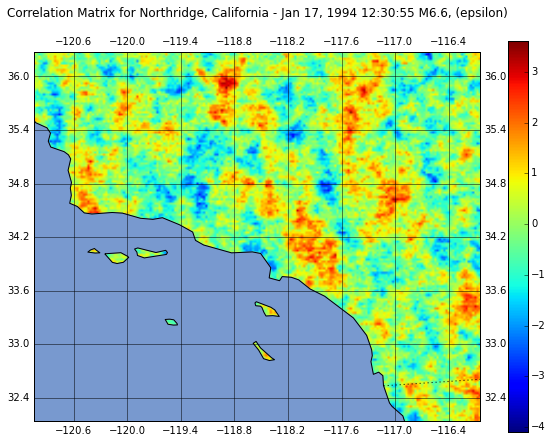

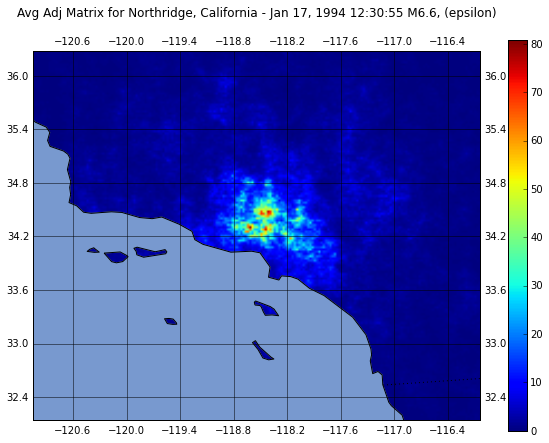

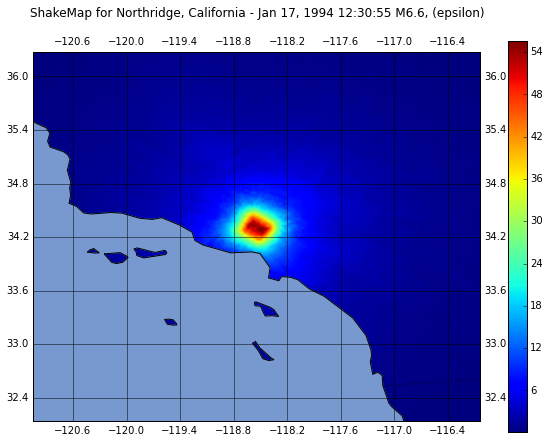

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from neicio.readstation import readStation
from neicio.shake import ShakeGrid
from neicio.gmt import GMTGrid
import time
from matplotlib import cm
from Correlation.setup import initialize
from Correlation.loop import main
from Correlation.realizations import realizations
from Correlation.plotting import plot

# Variable of interest                                                                                                                                                                                                        
voi = 'PGA'

# Specify the radius of interest                                                                                                                                                                                              
r = 15

# Specify number of realizations
num_realizations = 1

# Intensity Factor
intensity_factor = 0.9

# Get shakemap for desired variable, PGA, uncertainty grid and stationdata                                                                                                                                                    
# Selected Stations: Units in pctg                                                                                                                                                                                            
shakemap = ShakeGrid('/Input/grid.xml', variable = '%s' % voi)

# Uncertainty Data: Units in ln(pctg)                                                                                                                                                                                         
uncertainty = ShakeGrid('/Input/uncertainty.xml', variable= 'STD%s' % voi)

# Station Data: Units in pctg                                                                                                                                                                                                 
stationlist = '/Input/stationlist.xml'
stationdata = readStation(stationlist)

print np.size(stationdata['pga'])
# Sets up grid spacing, site collections, and other data values
# optional parameters: dm, dn, the grid discritization defaulting to 1
variables = initialize(shakemap, uncertainty, stationdata)

# Calculate the random array, stored for testing
rand = np.random.randn(variables['N']*variables['M'])

# Main program for computing spatial correlation
# Output is a dictionary with the following keys
#     cor- grid of spatially correlated epsilon                                                                                                                                
#     data- grid of ShakeMap data                                                                                                                                              
#     data_new- data with added spatial correlation                                                                                                                            
#     grid_arr- array for storing grid indices for multiple realizations                                                                                                       
#     mu_arr- array for storing Sig21.T*Sig11inv for multiple realizations                                                                                                     
#     sigma_arr- array for storing sigma for multiple realizations  
out = main(variables, r, voi, rand, intensity_factor)

# Calculate multiple realizations
ACCUM_ARRAY = realizations(num_realizations, variables['N'], variables['M'], out['grid_arr'], 
                           out['mu_arr'], out['sigma_arr'], variables['uncertaintydata'], out['data'])

plot(out, variables, voi, shakemap, stationdata, ACCUM_ARRAY)